In [28]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import lightgbm as lgb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold
import random
from sklearn.preprocessing import LabelEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if "KAGGLE_URL_BASE" in os.environ:
    raw_path = "/kaggle/input/cmi-detect-behavior-with-sensor-data"
else:
    raw_path = "../data/raw"

seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from src.feature_engineer import rotation_feature_engineer, accelrometer_feature_engineer
from src.data_cleaning import clean_df

In [30]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

tof_of_interest = ["tof_1_v20", "tof_2_v26", "tof_3_v17", "tof_4_v5"]
full_df = full_df.drop(columns=[col for col in full_df.columns if col not in tof_of_interest and  col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_2_v26,tof_3_v17,tof_4_v5,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,122.0,57.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,124.0,68.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,133.0,97.0,107.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,151.0,113.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,207.0,121.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,62.0,219.0,93.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,58.0,216.0,82.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,56.0,208.0,83.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,59.0,210.0,91.0,1,30,0,1,186.0,55,30.0


In [ ]:
cleaned_df, target_gestures = clean_df(full_df, drop_rot_na=True, drop_thm_na=False, min_gesture_count=26, max_gesture_count=38)
cleaned_df = rotation_feature_engineer(cleaned_df)
cleaned_df = accelrometer_feature_engineer(cleaned_df)

cleaned_df

[rot_na] Remaining: 255817/255817 (-0, 0.0% dropped)
[gesture_len outliers] Remaining: 241893/255817 (-13924, 5.4% dropped)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,angular_vel_z,angular_speed,fft_linear_acc_x,fft_linear_acc_y,fft_linear_acc_z,acc_mag,jerk_acc_x,jerk_acc_y,jerk_acc_z,jerk_mag
0,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.000000,0.000000,5297.395963,10736.157005,832.627230,9.924192,0.000000,0.000000,0.000000,0.000000
1,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,0.866171,5.950586,18.005330,48.635115,11.711802,10.113299,0.106349,-0.080353,0.297627,0.326111
2,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,-6.557898,7.828564,40.580388,56.754995,15.324921,10.536305,0.644451,0.673234,0.322615,0.986226
3,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,-4.311011,17.631206,139.285640,2.877701,9.937450,9.782531,0.189992,-1.107950,-0.266803,1.155350
4,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,-0.930412,4.551592,9.835400,8.273737,7.254863,9.925453,-0.723718,-0.259408,0.076626,0.772614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296015,SEQ_065531_000052,Non-Target,SEQ_065531,54,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,0.130400,9.145770,1.647547,10.574324,0.000000,0.000000,0.000000,0.000000
296016,SEQ_065531_000052,Non-Target,SEQ_065531,55,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,5.795799,1.203730,5.355061,10.574324,0.000000,0.000000,0.000000,0.000000
296017,SEQ_065531_000052,Non-Target,SEQ_065531,56,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,3.683352,42.347044,15.153375,10.574324,0.000000,0.000000,0.000000,0.000000
296018,SEQ_065531_000052,Non-Target,SEQ_065531,57,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,4.299387,6.912813,12.292207,10.574324,0.000000,0.000000,0.000000,0.000000


In [ ]:
feautures_of_interest = [
    # "acc_x",
    # "acc_y",
    # "acc_z",
    "linear_acc_x",
    "linear_acc_y",
    "linear_acc_z",
    # "acc_mag",
    "linear_acc_mag",
    "fft_linear_acc_x",
    "fft_linear_acc_y",
    "fft_linear_acc_z",
    # "jerk_acc_x",
    # "jerk_acc_y",
    # "jerk_acc_z",
    "jerk_mag",
    "rotvec_x",
    "rotvec_y",
    "rotvec_z",
    "rot_angle",
    "angular_vel_x",
    "angular_vel_y",
    "angular_vel_z",
    "angular_speed",
    "tof_1_v20",
    "thm_2",
    "thm_4",
    "thm_5",
]

sequence_groups = cleaned_df.groupby('sequence_id')
target_df = sequence_groups['gesture'].first()
encoder = LabelEncoder().fit(target_df)


# full time lenght features
features_full_seq = np.array([group for _, group in sequence_groups[feautures_of_interest]], dtype=np.float32) # N x n_timesteps x n_features
features_full_seq = torch.tensor(features_full_seq.transpose(0, 2, 1).copy() )# N x n_features x n_timestpes

target_np = encoder.transform(target_df).astype(np.int64) # type: ignore
target_tensor = torch.tensor(target_np)

target_gestures_encoded = torch.tensor(encoder.transform(target_df))

features_full_seq.shape, target_tensor.shape

(torch.Size([7790, 16, 38]), torch.Size([7790]))

In [ ]:
from src.model import GaussianNoise, ReSEBlock, LSTMBlock, GRUBlock, AttentionBlock


class FullModel(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.noise_layer = nn.Sequential(
            GaussianNoise(stddev=0.09),
        )
        self.res_connection = nn.Sequential(
            ReSEBlock(in_channels, 64, stride=2),
            # ReSEBlock(64, 64, stride=2),
            ReSEBlock(64, 128, stride=2),
        )
        self.lstm_layer = LSTMBlock(128, hidden_dim=128, layer_dim=1)  # 64 + 64 // 2
        self.gru_layer = GRUBlock(128, hidden_dim=128, layer_dim=1)

        self.temporal_attention = nn.Sequential(
            AttentionBlock(in_channels=4 * 128),
        )

        self.shortcut_branch = nn.Sequential(
            GaussianNoise(stddev=0.09),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 16),
            nn.ELU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(4 * 128 + 16, 256),  # Match author's layers
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes),
        )

    def forward(self, x: torch.Tensor):
        """
        X shape: N x n_features x time_steps
        """
        x = self.noise_layer(x)
        out_cnn: torch.Tensor = self.res_connection(x)  # B x F x (T // n)

        out_recurrent = out_cnn.transpose(2, 1)  # B x (T // n) x F
        out_lstm = self.lstm_layer(out_recurrent)  # B x (T // n) x (hidden_dim * 2)
        out_gru = self.gru_layer(out_recurrent)  # B x T_cnn_out x (hidden_dim * 2)
        out_recurrent = torch.cat([out_lstm, out_gru], dim=2)  # B x T x F
        out_recurrent = self.temporal_attention(out_recurrent)  # B x F

        out_shortcut = self.shortcut_branch(out_cnn)  # B x 16
        out = torch.cat([out_recurrent, out_shortcut], dim=1)

        y_pred = self.fc(out)

        return y_pred


class MiniModel(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.noise_layer = nn.Sequential(
            GaussianNoise(stddev=0.09),
        )
        self.res_connection = nn.Sequential(
            ReSEBlock(in_channels, 40, stride=2),
            # ReSEBlock(20, 40, stride=2),
        )
        # self.lstm_layer = LSTMBlock(40, hidden_dim=40, layer_dim=1) # 64 + 64 // 2
        self.gru_layer = GRUBlock(40, hidden_dim=40, layer_dim=1)

        self.temporal_attention = nn.Sequential(
            AttentionBlock(in_channels=2 * 40),
        )

        self.shortcut_branch = nn.Sequential(
            GaussianNoise(stddev=0.09),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(40, 16),
            nn.ELU(),
        )

        self.fc = nn.Sequential(nn.Linear(2 * 40 + 16, 40), nn.BatchNorm1d(40), nn.ReLU(), nn.Dropout(0.5), nn.Linear(40, n_classes))

    def forward(self, x: torch.Tensor):
        """
        X shape: N x n_features x time_steps
        """
        x = self.noise_layer(x)
        out_cnn: torch.Tensor = self.res_connection(x)  # B x F x (T // n)

        out_recurrent = out_cnn.transpose(2, 1)  # B x (T // n) x F
        out_lstm = self.gru_layer(out_recurrent)  # B x (T // n) x (hidden_dim * 2)
        out_recurrent = self.temporal_attention(out_lstm)  # B x F

        out_shortcut = self.shortcut_branch(out_cnn)  # B x 16
        out = torch.cat([out_recurrent, out_shortcut], dim=1)

        y_pred = self.fc(out)

        return y_pred


dummy_input = torch.rand(64, 15, 35)  # B x F x T
dummy_model = MiniModel(in_channels=15, n_classes=len(encoder.classes_))
dummy_model(dummy_input).shape
# dummy_attention_model = AttentionBlock(35)
# dummy_attention_model(dummy_input).shape # expected output: 64 x 35

torch.Size([64, 18])

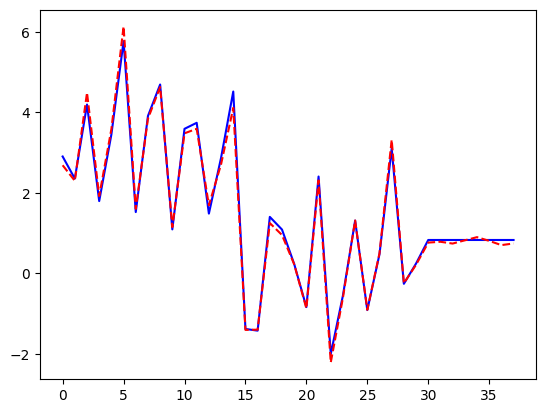

In [36]:
noise_block = GaussianNoise(0.09)
sample = features_full_seq[21,1, :]
sample_noised = noise_block(sample)

plt.plot(range(len(sample)), sample, 'b')
plt.plot(range(len(sample)), sample_noised, 'r--')

In [37]:
# FacePlant? aka what the fuck am i doing with my life
n_splits = 5
gkf = GroupKFold(n_splits)
subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])

n_features = features_full_seq.shape[1]
batch_size = 64
n_epochs = 101

test_subjects = []
lgbm_folds_score = []
cnn_folds_score = []
cnn_folds_score_train = []
importances = []

subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=features_full_seq, y=target_tensor, groups=subject_per_sequence)): # type: ignore
    # ---Prepare
    print(f"\n------FOLD {fold + 1}/{n_splits}------\n")
    if fold >= 3:
        break
    test_subjects.append(np.unique(subject_per_sequence[test_indices]))
    X_train, y_train = features_full_seq[train_indices], target_tensor[train_indices] # B x F x T
    X_test, y_test = features_full_seq[test_indices], target_tensor[test_indices]
    
    mean = X_train.mean(dim=(0, 2)).view(1, -1, 1)   # shape (1xFx1)
    std  = X_train.std(dim=(0, 2), unbiased=False).view(1, -1, 1) + 1e-8  # shape (1xFx1)

    # Normalize
    X_train = (X_train - mean) / (std + 1e-14)
    X_test  = (X_test  - mean) / (std + 1e-14)
    
    dataset_train = TensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # uh not sure if i should keep shuffle or no
    # ---End prepare
    
    model = MiniModel(in_channels=n_features, n_classes=len(encoder.classes_)).to(device)
    model.train()
    train_model(model, dataloader_train, n_epochs, True, lr=5e-3, weight_decay=3e-4, n_classes=len(encoder.classes_))
    
    model.eval()
    y_pred = torch.argmax(model(X_test.to(device)), dim=1)
    score_dashboard = evaulate_model(y_pred.to(device), y_test.to(device), target_gestures_encoded, encoder)
    cnn_folds_score.append(score_dashboard)
    
    y_pred = torch.argmax(model(X_train.to(device)), dim=1) 
    score_dashboard = evaulate_model(y_pred.to(device), y_train.to(device), target_gestures_encoded, encoder)
    cnn_folds_score_train.append(score_dashboard)

    print(f"test macro: {cnn_folds_score[-1]['f1_macro']}, train macro: {cnn_folds_score_train[-1]['f1_macro']}")


------FOLD 1/5------

0 - loss_avg: 2.5100, lr: 0.005000
20 - loss_avg: 2.0135, lr: 0.005000
40 - loss_avg: 1.9555, lr: 0.005000
60 - loss_avg: 1.9014, lr: 0.005000
80 - loss_avg: 1.9384, lr: 0.005000
100 - loss_avg: 1.8354, lr: 0.005000
test macro: 0.45201295050164486, train macro: 0.5360693898594492

------FOLD 2/5------

0 - loss_avg: 2.5015, lr: 0.005000
20 - loss_avg: 2.0342, lr: 0.005000
40 - loss_avg: 1.9580, lr: 0.005000
60 - loss_avg: 1.8782, lr: 0.005000
80 - loss_avg: 1.8613, lr: 0.005000
100 - loss_avg: 1.8323, lr: 0.002500
test macro: 0.5620418061471271, train macro: 0.612812998517058

------FOLD 3/5------

0 - loss_avg: 2.4893, lr: 0.005000
20 - loss_avg: 2.0102, lr: 0.005000
40 - loss_avg: 1.9526, lr: 0.005000
60 - loss_avg: 1.9000, lr: 0.005000
80 - loss_avg: 1.9332, lr: 0.005000
100 - loss_avg: 1.8950, lr: 0.005000
test macro: 0.5239141808725429, train macro: 0.6053068203151397

------FOLD 4/5------



CNN FOLD SCORE
test - macro: 0.513, binary: 1.000, competition: 0.756
train - macro: 0.585, binary: 1.000, competition: 0.792


,precision,recall,f1-score,support
Above ear - pull hair,0.422680,0.425585,0.422995,125.333333
Cheek - pinch skin,0.233713,0.096366,0.131731,124.333333
Drink from bottle/cup,0.806397,0.778853,0.779999,30.333333
Eyebrow - pull hair,0.279925,0.139402,0.180891,126.333333
Eyelash - pull hair,0.391328,0.521827,0.442839,126.333333
Feel around in tray and pull out an object,0.587402,0.821445,0.640777,13.000000
Forehead - pull hairline,0.443398,0.469459,0.451533,126.333333
Forehead - scratch,0.404749,0.697076,0.511632,125.666667
Glasses on/off,0.796537,0.769697,0.766455,21.333333
Neck - pinch skin,0.350380,0.114311,0.165411,125.333333


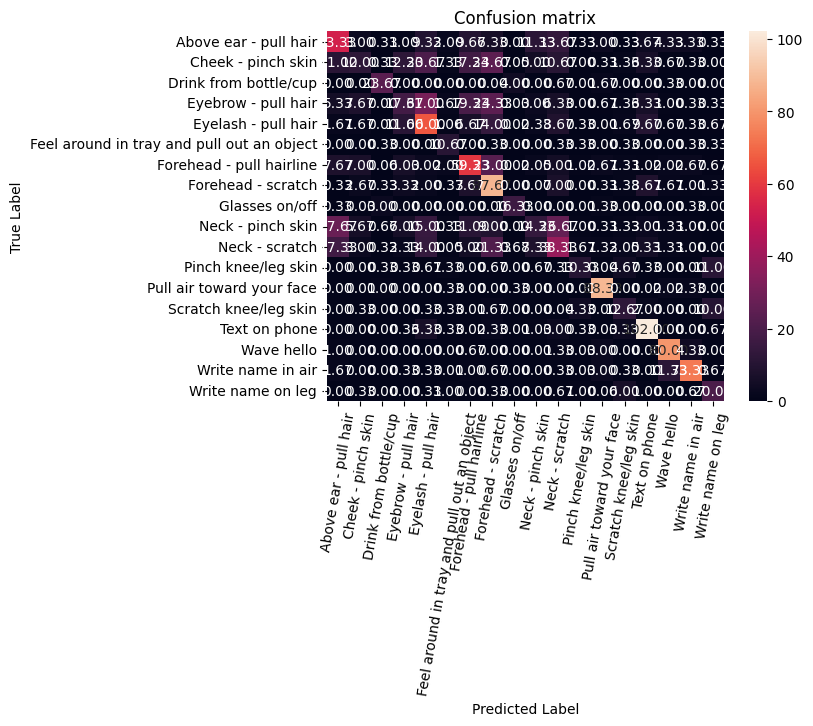

In [38]:
print("CNN FOLD SCORE")
fold_scores = cnn_folds_score
fold = get_avg_fold(cnn_folds_score)
fold_train = get_avg_fold(cnn_folds_score_train)

macro = fold["f1_macro"]
binary = fold["f1_binary"]
competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

macro_train = fold_train["f1_macro"]
binary_train = fold_train["f1_binary"]
competition_eval_train = fold_train["competition_evaluation"]
cm_train = fold_train['confusion_matrix']

print(f'test - macro: {macro:.3f}, binary: {binary:.3f}, competition: {competition_eval:.3f}')
print(f'train - macro: {macro_train:.3f}, binary: {binary_train:.3f}, competition: {competition_eval_train:.3f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]